In [125]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder  

In [126]:
try:
    df = pd.read_json('problems_data.jsonl', lines=True)
except ValueError:
    print("Error: check filetype again")
    exit()

In [127]:
df = df.dropna(subset=['problem_score', 'problem_class'])
le = LabelEncoder()
df['difficulty_label'] = le.fit_transform(df['problem_class'])
class_mapping = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))} #int(v) so int64 doesn't come
print("Mapping:", class_mapping) #yo remember hard is 1
text_columns = ['title', 'description', 'input_description', 'output_description']
for col in text_columns:
    df[col] = df[col].fillna('')

df['combined_text'] = (
    df['title'] + " " + 
    df['description'] + " " + 
    df['input_description'] + " " + 
    df['output_description']
)

def upd(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = " ".join(text.split())
    return text

df['combined_text'] = df['combined_text'].apply(upd)

Mapping: {'easy': 0, 'hard': 1, 'medium': 2}


In [128]:
hard_topics = [
    'convex hull', 'mobius', 'segment tree', 'flow', 'centroid', 
    'geometry', 'gcd', 'mex', 'dynamic programming', 
    'modulo', 'bitwise', 'graph', 'expected value','permutations','xor','shortest path','grid','query','range','range query'
]
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    col_name = f'has_{topic.replace(" ", "_")}'
    df[col_name] = df['combined_text'].str.contains(topic, case=False).astype(int)  

df['hard_topic_count'] = 0
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    df['hard_topic_count'] += df['combined_text'].str.contains(topic, case=False).astype(int)
    
                                                                            
df['is_short_statement'] = (df['combined_text'].str.len() < 300).astype(int)
df['text_len'] = df['combined_text'].apply(len)
mathsym = ['$', '^', '{', '}', '_', '\\', '=', '<', '>','*']
df['math_count'] = 0
for j in range(len(mathsym)):
    sym = mathsym[j]
    df['math_count'] += df['combined_text'].str.count(re.escape(sym))
df['has_high_constraints'] = df['combined_text'].str.contains(r'10\^5|10\^9|1000000007|1e9|1e5', regex=True).astype(int)
df['math_density'] = df['math_count'] / (df['combined_text'].str.len() + 1)

In [135]:
import pandas as pd
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

def get_class_probs(df):
    classes = [0, 1, 2] 
    class_data = {}
    
    for cls in classes:
        subset = df[df['difficulty_label'].isin([cls, str(cls)])]['combined_text'].dropna()
        
        if len(subset) == 0:
            print(f"Warning: No data found for class {cls}. Skipping...")
            class_data[str(cls)] = {}
            continue
            
        vec = CountVectorizer(binary=True, token_pattern=r"(?u)\b\w+\b")
        try:
            matrix = vec.fit_transform(subset)
            probs = matrix.sum(axis=0).A1 / len(subset)
            class_data[str(cls)] = dict(zip(vec.get_feature_names_out(), probs))
        except ValueError:
            class_data[str(cls)] = {}
            
    return class_data

probs = get_class_probs(df)
all_words = set(probs['0'].keys()) | set(probs['1'].keys()) | set(probs['2'].keys())
feature_scores = []

for word in all_words:
    p0 = probs['0'].get(word, 0)
    p1 = probs['1'].get(word, 0) 
    p2 = probs['2'].get(word, 0) 
    
    spread = max(p0, p1, p2) - min(p0, p1, p2)
    is_noise = (p0 > 0.25 and p1 > 0.25 and p2 > 0.25)
    feature_scores.append({'word': word, 'spread': spread, 'is_noise': is_noise})

features_df = pd.DataFrame(feature_scores)
new_cp_stopwords = features_df[features_df['is_noise'] == True]['word'].tolist()
print(new_cp_stopwords)
cp_manual_stop = [
    'input', 'output', 'line', 'number', 'integer', 'integers', 
    'problem', 'given', 'contains', 'possible', 'single', 'test', 
    'case', 'cases', 'print', 'outputting', 'standard', 'format', 'program', 'write', 'le', 'leq', 'consists', 'help',
    'containing', 'contain', 'time', 'giving', 'following', 'exactly','completely','satisfy','loves','love',
]

merged_stopwords = list(set(cp_manual_stop).union(set(new_cp_stopwords)))
final_stopwords = list(text.ENGLISH_STOP_WORDS.union(merged_stopwords))


tfidf = TfidfVectorizer(
    max_features=3000, 
    stop_words=final_stopwords, 
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df['combined_text'])
hard_dist = probs['1']
med_dist = probs['2']
easy_dist = probs['0']
mediumvec = []
hardvec = []
for word, prob in hard_dist.items():
    if word in final_stopwords:
        continue
    p_m = med_dist.get(word, 0)
    p_e = easy_dist.get(word, 0)
    if prob > 2*p_m:
        hardvec.append((word, prob))

for word, prob in med_dist.items():
    if word in final_stopwords:
        continue
    p_h = hard_dist.get(word, 0)
    p_e = easy_dist.get(word, 0)
    if prob > 2*p_h:
        mediumvec.append((word, prob))
print(len(hardvec))
hardvec.sort(key=lambda x: x[1], reverse=True)
# print("Top 15 Hard-Only Signals:")
# for word, prob in hardvec[:15]:
#     print(f"{word}: {prob:.4f}")
hard_keywords = [word for word, prob in hardvec[:30]] # Take the top 20
mediumvec.sort(key=lambda x: x[1], reverse=True)
medium_keywords = [word for word, prob in mediumvec[:30]]

df['high_difficulty_signal_count'] = df['combined_text'].apply(
    lambda x: sum(1 for word in hard_keywords if word in x.lower())
)
df['medium_signal_count'] = df['combined_text'].apply(
    lambda x: sum(1 for word in medium_keywords if word in x.lower())
)
X_manual = df[['hard_topic_count', 'math_density', 'text_len', 'high_difficulty_signal_count','is_short_statement','has_high_constraints','medium_signal_count']].values
X_manual[:, -1] *= 5 
Xf = sp.hstack((X_tfidf, X_manual))

print("Feature Matrix Shape:", Xf.shape)


['two', 'at', '000', 'output', 'n', 'the', 'by', 'consists', 'has', 'have', 'up', 'where', 'not', 'so', 'are', 'all', 'le', '1', 'you', 'single', '10', 'no', 'number', 'line', 'there', 'if', 'a', 'of', 'input', 'is', 'leq', 'contains', 'be', 'how', 'on', 'lines', 'to', 'each', 'as', 'most', 'and', 'integer', '0', 'can', 'in', 'with', 'containing', 't', '2', 'or', 's', 'will', 'given', 'when', 'should', 'this', 'order', 'then', 'integers', 'they', 'an', 'first', 'one', 'but', 'it', 'only', 'for', 'which', 'from', 'your', 'that']
8384
Feature Matrix Shape: (4112, 3007)


In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Xf, 
    df['difficulty_label'], 
    test_size=0.3, 
    random_state=7,   #rerun doesn't changes it
    stratify=df['difficulty_label']  #maintain a good ratio
)

print(f" on {X_train.shape[0]} problems...")

 on 2878 problems...


In [131]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([
    ('svd', TruncatedSVD(n_components=700, random_state=7)),
    ('clf', RandomForestClassifier(oob_score=True, random_state=7))
])

param_grid = {
    'svd__n_components': [100, 200],
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['sqrt', 0.2],
    'clf__max_depth': [None, 30],
    'clf__min_samples_leaf': [1, 3],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("CV score:", gs.best_score_)
best = gs.best_estimator_
y_pred = best.predict(X_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   3.0s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   3.0s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.9s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf

Out of Bag Score: 0.5330


Test Accuracy: 0.5300


Model Accuracy: 0.53


              precision    recall  f1-score   support

        easy       0.45      0.47      0.46       230
        hard       0.59      0.73      0.66       582
      medium       0.43      0.28      0.34       422

    accuracy                           0.53      1234
   macro avg       0.49      0.50      0.49      1234
weighted avg       0.51      0.53      0.51      1234



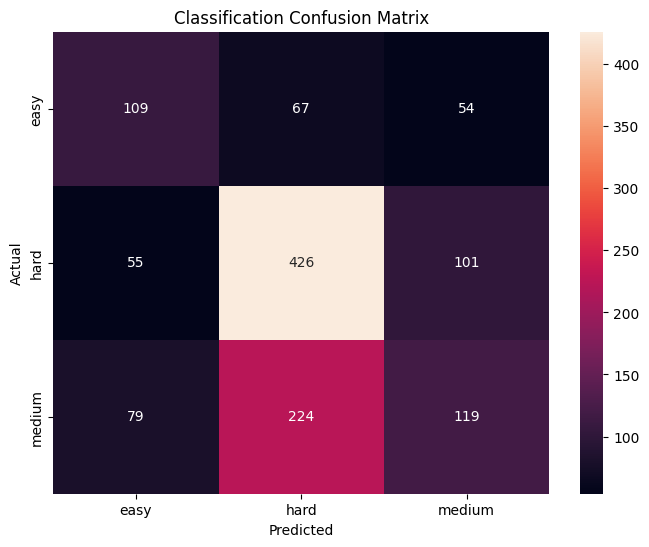

In [132]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=500, 
    max_features='sqrt', 
    class_weight='balanced_subsample', 
    min_samples_leaf=3,              
    oob_score=True,
    random_state=7,
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Out of Bag Score: {clf.oob_score_:.4f}")
print("\n")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")
print("\n")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()


In [133]:

importances = clf.feature_importances_
feature_names = list(tfidf.get_feature_names_out()) + ['hard_topic_count', 'math_count', 'text_len', 'math_density']
importance_dict = dict(zip(feature_names, importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("TOP 10 FEATURES THE MODEL ACTUALLY USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)
print("TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")

TOP 10 FEATURES THE MODEL ACTUALLY USED:
text_len: 0.0313
math_density: 0.0173
possible: 0.0158
math_count: 0.0148
hard_topic_count: 0.0089
program: 0.0075
write: 0.0073
100: 0.0070
write program: 0.0067
print: 0.0064
TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:
28: 0.0000
_1: 0.0000
_2: 0.0000
ability: 0.0000
active: 0.0000
activities: 0.0000
agency: 0.0000
alex: 0.0000
alf: 0.0000
aliens: 0.0000


Out of Bag Score: 0.5094

Test Accuracy: 0.4927

Model Accuracy: 0.49

              precision    recall  f1-score   support

        easy       0.43      0.13      0.19       230
        hard       0.53      0.84      0.65       582
      medium       0.38      0.22      0.28       422

    accuracy                           0.49      1234
   macro avg       0.45      0.39      0.37      1234
weighted avg       0.46      0.49      0.44      1234



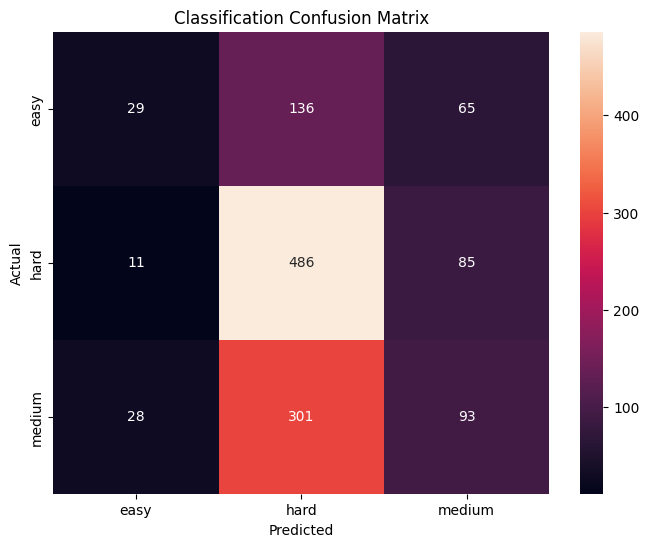

In [134]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

try:
    # prefer GridSearch result
    model_used = best
    y_pred = best.predict(X_test)
except NameError:
    # fallback: train local clf
    model_used = RandomForestClassifier(
        n_estimators=300,
        max_features='sqrt',
        class_weight='balanced_subsample',
        min_samples_leaf=3,
        oob_score=True,
        random_state=7,
    )
    model_used.fit(X_train, y_train)
    y_pred = model_used.predict(X_test)

# print OOB if available
oob = None
try:
    oob = model_used.oob_score_
except Exception:
    try:
        oob = model_used.named_steps['clf'].oob_score_
    except Exception:
        oob = None

if oob is not None:
    print(f"Out of Bag Score: {oob:.4f}")
    print()

print(f"Test Accuracy: {model_used.score(X_test, y_test):.4f}")
print()
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print()
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()